In [ ]:
!pip install -q git+https://github.com/keras-team/keras-tuner
import kerastuner as kt
import tensorflow_datasets as tfds
import tensorflow as tf

# prepare data for demonstration
data = tfds.load('mnist')
train_ds, test_ds = data['train'], data['test']

def standardize_record(record):
    return (tf.cast(record['image'], tf.float32) / 255.,
            tf.one_hot(record['label'], 10))

train_ds = train_ds.map(standardize_record).cache().batch(64).shuffle(10000)
test_ds = test_ds.map(standardize_record).cache().batch(64)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


A small multi-layer percepton model for the tutorial.



In [ ]:
class SimpleMLP(kt.HyperModel):
  def __init__(self,
               x_shape,
               y_shape,
               max_depth=5,
               max_units=10,
               min_units=3,
               min_depth=3):
    self.max_depth = max_depth
    self.min_depth = min_depth

    self.max_units = max_units
    self.min_units = min_units

    self.x_shape = x_shape
    self.y_shape = y_shape

  def build(self, hp):
    depth = hp.Int('depth', self.min_depth, self.max_depth)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=self.x_shape))
    model.add(tf.keras.layers.Flatten())
    for i in range(depth):
      units_i = hp.Int(f'units_{i}', self.min_units, self.max_units)
      model.add(tf.keras.layers.Dense(units_i, activation='relu'))
    
    model.add(tf.keras.layers.Dense(self.y_shape))
    optimizer = hp.Choice('optimizer', ['sgd', 'adam'])
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['accuracy'])
    return model

Keras Tuner is an easy-to-use, distributable hyperparameter optimization framework that solves the pain points of performing a hyperparameter search. Keras Tuner makes it easy to define a search space and leverage included algorithms to find the best hyperparameter values. Keras Tuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in, and is also designed to be easy for researchers to extend in order to experiment with new search algorithms.

# 0. Highest level overview


To understand how Keras Tuner works, there are three main classes that interact in the tuning loop: HyperModel, Oracle and Tuner. Tuner controls the entire workflow of repeatedly creating models, training and evaluating, and building new one based on previous results. The HyperModel is responsible for providing the pipeline to build model. The oracle is responsible for the algorithm that determines what to try in each step. 




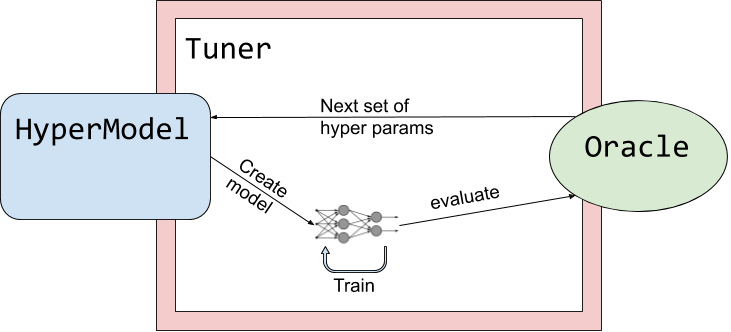


For the built in oracles, each oracle have a corresponding tuner class that includes a simple `MultiExectionTuner` and the oracle itself, and hence can be initialize in one line as `tuner = kt.tuners.randomsearch.RandomSearch()` for example. 

Each complete cycle in the Tuner is called a `trial`. 

In [ ]:
hypermodel = SimpleMLP([28, 28,1], 10)
oracle = kt.tuners.randomsearch.RandomSearchOracle(objective='val_accuracy', max_trials=10)
tuner = kt.Tuner(oracle, hypermodel, overwrite=True)
# the use of tuner.search is similar to model.fit()
tuner.search(train_ds, validation_data=test_ds, epochs=10)

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.2451000064611435

Best val_accuracy So Far: 0.6685000061988831
Total elapsed time: 00h 03m 16s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
m = tuner.get_best_models()[0]
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 63        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 48        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                70        
Total params: 8,119
Trainable params: 8,119
Non-trainable params: 0
______________________________________________________

# 1. hyperparameters - what hapens in each trial?

In order to set hyperparameter search space or the tuning process, we need to know how Keras Tuner passes around the information about the hyperparameters.
In Keras Tuner we have two classes, `HyperParameters` and `HyperParameter`. An object in class `HyperParameters` (hereafter `hps`) is a container of multiple objects of `HyperParameter` (hereafter `hp`). Each `hp` carries information of the allowed choices or range of a hyperparameter that we will search. Also, each `hp` is assigned with a concrete value in `hps` that is allowed by `hp`. Such `hps` objects carries all messages about the hyperparameters used for building the model. 





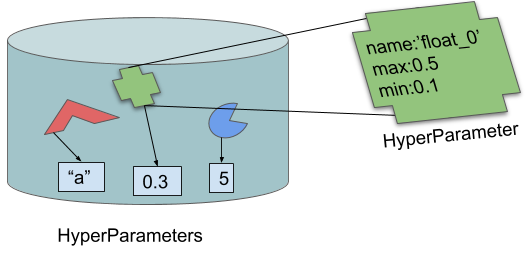

It is important to note that `hps` objects represent the internal message passing mechanism, and are repeatedly created and discarded along the lifetime of a `tuner`. It is always created by the `tuner` within a `trial`. After it is created, it visits `oracle` to get assigned values corresponding to each `hp` (we will discuss how `oracle` decide what to assign), and then bring the assigned values to `hypermodel` to create a new model. While building the model, the `hps` also updates itself when `hypermodel` is trying to use a `hp` that `hps` does not already contain.

In the illustration below, in a `trial`, the `hps` (1) inquires value from the `oracle`, then (2) is fed into the `hypermodel` who uses the values recorded in `hps` to build a model, whereas (3) if an unseen `hp` is encountered, the `hp` is created inside `hps` with a default value, and finally (4) the information in the `hps` is recorded by `oracle` together with the `score` of this `trial`. Now it is ready for the next cycle.

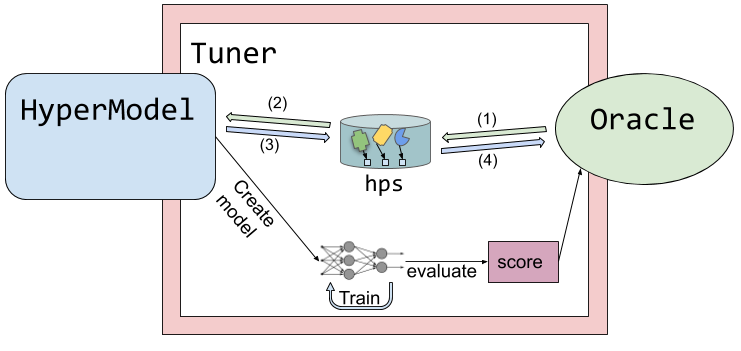

Again, when using Keras-Tuner, for most of the times we are building a pipeline to pass around `hps` objects, make change to the content or retrieve value from them. Hence we usually do *not* explicitly create `hps` object. The *only* situation to manually initiate `hps` is outside of the `tuner`, when we want to pass external information into the tuning loop.

#2 How to define search space: HyperModel

Now we focus on (2) and (3), where the search space for the hyperparameter tuning is determined. 

An object in `HyperModel` class has a `build` function as a pipeline to build model. The signature of `build` function is always
```python
def build(self, hps):
  # build the model
  ...
  float_0 = hps.Float('float_0', 0.1, 0.5)
  # continue building the model while using `float_0` when needed
  ...
  return model
```
with various hyperparameters to be filled in using `hps`, where the `hps` argument will take the `hps` in each `trial`.




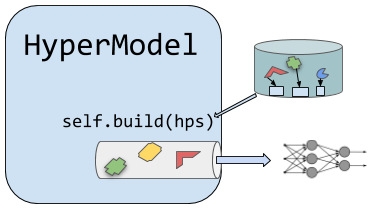

 In this pipeline, if the `hps` that is passes in already contains the `hp` with name 'float_0', then `float_0` will be assigned the value provided by `hps`. If a never seen `hp` is seen, corresponding `hp` is added to the `hps` and a default value is assigned. Hence, as `hypermodel` builds the model, it is also populating the search space.


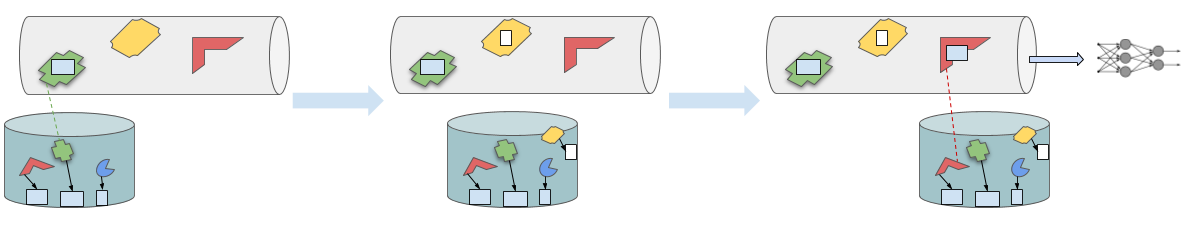

In [ ]:
NUM_CLASSES = 10

class MyHyperModel(kt.HyperModel):
  def build(self, hps):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(28, 28, 1)))
    model.add(tf.keras.layers.Flatten())
    for i in range(4):
      units_i = hps.Int(f'units_{i}', min_value=3, max_value=5)
      model.add(tf.keras.layers.Dense(units_i, activation='relu'))

    model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

hypermodel = MyHyperModel()
oracle = kt.tuners.randomsearch.RandomSearchOracle(objective='val_accuracy', max_trials=10)
tuner = kt.Tuner(oracle, hypermodel, overwrite=True)
tuner.search_space_summary()
tuner.search(train_ds, validation_data=test_ds, epochs=10)

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.593500018119812

Best val_accuracy So Far: 0.8485000133514404
Total elapsed time: 00h 03m 11s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Note: instead of creating a subclass of `HyperModel`, we can also use a function that takes `hps` and returns `model` in the place of a hypermodel. In such a case, the `tuner` will automatically create a `HyperModel` that wraps the model building function. 

`hypermodel` does not create `hps`, but only add new `hp` to `hps`. Besides, it never change the value of `hp` in `hps`, where new `hp` added to `hps` will assume the default value or random value by `hps`. That means within the `build` function, defining a `hp` for multiple times will get the same value on the same `trial`.

`hp` is never removed from `hps` even if it is not used. This makes `oracle` easier to keep track of the history of search.

#3 Define search algorithms

It is also possible to customize algorithms. The design of Keras Tuner completely abstracts the algorithm of tuning into `oracle`. Oracle can be thought of as a function that takes the full history of values in `hps` to determine the values for the next search. 

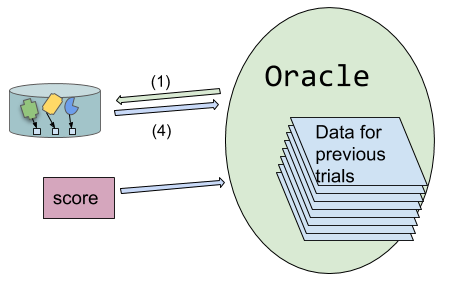

The simplest search algorithm, random search, would then be described as follows:

1.   Pick a random set of values that is allowed by the `hps`.
2.   Check if the value is already tried. Go to 1 if the set of value is used. If all possible values are already tried, trigger an end for the search.
3.   Update `hps` object with the set of value.

Usually an improved algorithm will attempt to change the behavior in step 1, making use of the previous scores. For example, Bayesian optimization (also provided in Keras-Tuner) utilizes a Gaussian process regression to determine a best choice for the upcoming test.

Note: `oracle` does not create `hps`, nor does it change any of the `hp` in `hps`. It only changes the values attached to it. 

For examples of implementing new `oracle`, see the existing ones as [examples](https://github.com/keras-team/keras-tuner/tree/master/kerastuner/tuners). Currently we provide `RandomSearch`, `BayesianOptimization` and `Hyperband`. Hyperparameter searching algorithms that consistently and significantly outperforms random search has been considered difficult to find. Hence it is usually adviced to start with `RandomSearch` if not sure what oracle to use.

# 4 Customizing `tuner`

It is also possible to define the behavior of the `tuner` by overriding `run_trial` method. A few possible occasions for needing to override `tuner` include
1.  Need to customize training loop rather than doing simply `fit`. For example, when transfer-learning we may want to `fit` the model for two times, first time with most layers of the model frozen and the second time unfrozen. See an example [here](https://www.kaggle.com/fuyixing/flower-classification-with-keras-tuner-and-kpl)
2.  Need to search hyperparameters that affect the behavior outside of the model building pipeline, for example if we want to tune number of epochs to train, as the example below. In this case, we need to use `trial.hyperparameters` to define new `hp`.

In [ ]:
class MyTuner(kt.Tuner):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        fit_kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 20)
        super(MyTuner, self).run_trial(trial, *fit_args, **fit_kwargs)

When customizing `tuner`, we should only override `run_trial` part which covers `hypermodel.build(hp)` to updating score of the model, and not including any direct interaction with `oracle`. Updating score can be done conveniently through adding `kt.tuner_utils.TunerCallback` to `fit`, or manually update using the [hooks](https://keras-team.github.io/keras-tuner/tutorials/subclass-tuner/#overriding-run_trial).

# Summary of hps, hypermodel, oracle and tuner

|   | hypermodel  | oracle  | tuner  |
|---|---|---|---|
| create `hps`  | no  | no  | yes  |
| add `hp` to `hps`  | when first encountered  | no  | maybe, within `run_trial`  |
| remove `hp` from `hps`  | no  | no  | no  |
| change value of `hp` in `hps` | no | yes | no |
